# Introduction 

- The categories in are available in tender_categories
- Data that is useful for categorization includes
  - 'tender_details'
  - 'tender_description' 
  - 'boq_items'
  - 'boq_details'
- After going through the features, we chose to combine the columns into a single string before feeding to the model
- Bag of words
  - We used a simple countvectorizer to make vectors based on word frequencies
  - Naive Bayes was used to analyze these vectors
  - Evaluation using the standard accuracy metric suggests that the model is good but when using balanced accuracy we can see that naive bayes does not perform well.
  - This is expected due to the skew in the data
- Word embeddings
  - We use the GoogleNews embedding to create better representations for the words
  - Naive Bayes is applied
  - It is observed that the overall accuracy improved but the balanced accuracy suffered

## Flow of logic

### Ingesting tenders
- Reading of data into pandas
- Fixing repeated columns
- Checking for uniqueness of information
  - boq_details and boq_items
  - tender_description and tender_details
  - tender_details and boq_details
### Feature engineering
- Creating labels
  - Plotting the skew in data
  - Looking for ways to combine labels
- Dropping additional columns
- Splitting the data into train and test set
### Bag of Word representation
- Representing the text as vectors: Countvectorizer
  - Combining tender_details and boq_details into a single string
  - Tokenizing the string using Spacy tokenizer
    - Training vector which can transform new instances
#### Using Naive Bayes
#### Evaluation
- Evaluation is carried out using the accuracy metric
- Evaluation is carried out using the balanced accuracy metric
- Since balanced accuracy is low, moving to word embeddings to see if there is an improvement
### Word embeddings
- Downloading GoogleNew embedding
- Transforming the train and test features 
#### Using Naive Bayes
#### Evaluation

# Prequisites

!pip install pandas
!pip install scipy
!pip install numpy
!pip install spacy
!pip install matplotlib
!python -m spacy download en_core_web_sm
!pip install scikit-learn

# Ingesting Tenders

In [ ]:
import pandas as pd

In [ ]:
tenders = pd.read_csv(
filepath_or_buffer='data/dataScienceAssignment/tender.csv',\
# This is the file path of the csv
# Get the column names from a header row
na_values='[]',
header=0,
)

In [ ]:
tendersTh.head()

## Fixing the extra index columns 

In [ ]:
tenders.loc[tenders['Unnamed: 0.1']!=tenders['Unnamed: 0']]

In [ ]:
tenders.loc[tenders.index!=tenders['Unnamed: 0']]

In [ ]:
tenders.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [ ]:
tenders.info()

## BOQ items and details equivalence

In [ ]:
tenders['boq_items'][0]

- Assuming that the quantity, units, rate, amount and '\_class' quantities do not affect the category of the item
- The only important information is the 'itemDescription'
- Observing that the column boq_details also contains similar information

Checking for equivalence of values in 'boq_items' & 'boq_details'

In [ ]:
from ast import literal_eval

In [ ]:
def boq_items_conv(rowitem):
    """Function to filter the items description from boq_items and add to list
    """
    boq_details = [] # List contain item descriptions
    if rowitem != '[]':
        boqitemslist = literal_eval(rowitem) # Literal evaluation of the bytes to convert to python list
        for item in boqitemslist:
            boq_details.append(item['itemDescription']) # Adding descriptions to the list
    return boq_details

In [ ]:
boq_items_conv(tenders['boq_items'][0])

In [ ]:
def boq_details_conv(rowitem):
    """ Function to convert the bytes in boq_details to python list
    """
    if rowitem != '[]':
        test = literal_eval(rowitem)
        return test

In [ ]:
tenders['boq_details'][80:90]

In [ ]:
boq_details_conv(tenders['boq_details'][0])

Listing out rows in which the lists are different

Since there are no such rows. We will drop the 'boq_items'

In [ ]:
tenders.drop(columns=['boq_items'], inplace=True)

In [ ]:
tenders.info()

## tender_description and tender_details equivalence

It appears that tender_description and tender_details are also very similar.
Printing the cases, where it is different.

In [ ]:
tenders.loc[tenders['tender_description']!=tenders['tender_details']][['tender_description','tender_details']].info()

In [ ]:
tenders.loc[tenders['tender_description']!=tenders['tender_details']][['tender_description','tender_details']].values

- It is observed that in the 20 cases, tender_description and tender_details don't match
- In these cases, tender_details has a copy of the information in tender_description and a few more details

In [ ]:
tenders.drop(columns=['tender_description'], inplace=True)

## tender_details and boq_details

In [ ]:
tenders[['tender_details', 'boq_details']][:5].values

- It appears that the data in both these items are different
- One might want to evaluate the usefulness of joining these two items to make a single column
- For the moment, I am going to fill all the NAN values in boq_details with the values in tender_details

# Feature Engineering

## Labels

Converting the tender_category column a form that can be fed to models

In [ ]:
tenders['tender_category'].unique()

The 'nan' objects are not useful and we will drop these rows from further analysis

In [ ]:
tenders.loc[tenders['tender_category'].isna()].count()

This amounts to ~10% of the total data available

In [ ]:
tenders.dropna(subset=['tender_category'], inplace=True)

Creating a labels column with normalized categories

In [ ]:
tenders['labels'] = tenders['tender_category'].map({'Works':1, 'WORKS':1, 'Services': 2, 'SERVICES': 2, 'Goods': 3, 'GOODS': 3, 'ITEM RATE': 4, 'PERCENTAGE': 5})

In [ ]:
tenders.drop(columns=['tender_category'], inplace=True)

Checking the spread of the data

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
tenders['labels'].hist()

Note the skew in the data towards 'Work' and 'Services' categories

In [ ]:
tenders.loc[tenders['labels']==4]['boq_details'].values

Checking to see if 'ITEM RATE' can be absorbed in the other categories

In [ ]:
tenders.loc[tenders['labels']==5]['boq_details'].values

Checking to see if 'PERCENTAGE' can be absorbed in the other categories

## Features

In [ ]:
tenders.info()

- tender_id is a unique number with no connection to the category
- boq_len also has no connection with the category

In [ ]:
tenders.drop(columns=['tender_id', 'boq_len'], inplace=True)

Ideally I would want to convert the text from tender_details and boq_details to vectors too but we intend to try out different ways of vectorizing them and will postpone to the sections below

## Split

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(tenders, test_size=0.2, random_state=1)

# Model selection and prediction

- There could be a relation between the first few words of tender_details and the label. We will try to capture the first few words of the description and use that as features

## Representation: Bag of words

### Transforming the natural language data

#### Combining columns to create a single feature string

In [ ]:
train_set['boq_details'].fillna('[]',inplace=True)

In [ ]:
test_set['boq_details'].fillna('[]',inplace=True)

Combining the line items in boq_details into a single string

In [ ]:
def boq_details_concat(rowitem):
    """ Function to convert the bytes in boq_details to python list
    """
    if rowitem is not None:
        test = literal_eval(rowitem)
        if test is not None:
            return ' '.join(test)
    else:
        return ''

In [ ]:
combined_features = train_set['tender_details'].values + train_set['boq_details'].map(boq_details_concat).values

In [ ]:
combined_features_test = test_set['tender_details'].values + test_set['boq_details'].map(boq_details_concat).values

#### Creating count vectors

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def spacy_tokenizer(document):
    tokens = nlp(document)
    tokens = [token.lemma_.lower() for token in tokens if (
        token.is_stop == False and \
        token.is_punct == False and \
        token.lemma_.strip()!= '')]
    return tokens

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer(input = 'content', tokenizer = spacy_tokenizer)

In [ ]:
train_features_td = vector.fit_transform(combined_features)

In [ ]:
test_features_td = vector.transform(combined_features_test)

In [ ]:
train_features_td

In [ ]:
test_features_td

## Model: Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [ ]:
tenders['labels'][1:8].values

In [ ]:
nb.fit(train_features_td,train_set['labels'])

In [ ]:
nb.predict(train_features_td[0])

In [ ]:
train_set['labels'][0]

## Evaluation

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_set['labels'],nb.predict(test_features_td))

Evaluation of accuracy could be done using the standard accuracy metric 

In [ ]:
from sklearn.metrics import accuracy_score

In [63]:
accuracy_score(test_set['labels'],nb.predict(test_features_td))

0.7368421052631579

Being greater than 70%, this seems like an okay result. 

However, we have seen that the other classes are not doing quite well.
A better metric that is able to capture the effectiveness to classify in imbalanced classes is the balanced accuracy

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [64]:
balanced_accuracy_score(test_set['labels'],nb.predict(test_features_td))

0.4642857142857143

With balanced accuracy, we can see that we the current model is not doing well and we should be exploring other models

# Representation: Word Embeddings

## Transforming the train and test data

In [3]:
from gensim.models import Word2Vec, KeyedVectors

In [4]:
import numpy as np

Download the model from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
And unzip it

In [5]:
path_to_model = 'GoogleNews-vectors-negative300.bin'

In [6]:
w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)

In [70]:
def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        if(count_for_this!=0):
            feats.append(feat_for_this/count_for_this) 
        else:
            feats.append(zero_vector)
    return feats

In [74]:
train_features_we = embedding_feats(combined_features)

In [76]:
test_features_we = embedding_feats(combined_features_test)

## Model: Naive Bayes

In [77]:
from sklearn.naive_bayes import MultinomialNB
nb_we = MultinomialNB()

In [79]:
from sklearn.preprocessing import MinMaxScaler

In [84]:
scaler = MinMaxScaler()
scaler.fit(train_features_we)

MinMaxScaler()

In [88]:
train_features_we_nb = scaler.transform(train_features_we)

In [89]:
nb_we.fit(train_features_we_nb,train_set['labels'])

MultinomialNB()

In [93]:
nb_we.predict(train_features_we_nb[0:5])

array([2, 1, 2, 2, 1])

In [94]:
train_set['labels'][0:5]

/tmp/ipykernel_1906073/77057964.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_set['labels'][0:5]


93    2
62    1
28    1
94    2
45    1
Name: labels, dtype: int64

### Evaluation

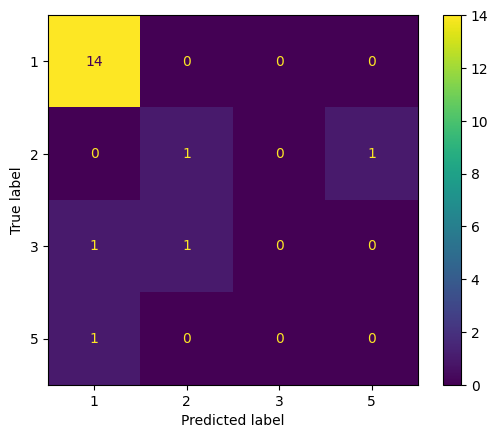

In [96]:
ConfusionMatrixDisplay.from_predictions(test_set['labels'],nb_we.predict(scaler.transform(test_features_we)))

Evaluation of accuracy could be done using the standard accuracy metric 

In [102]:
accuracy_score(test_set['labels'],nb_we.predict(scaler.transform(test_features_we)))

0.7894736842105263

In [101]:
balanced_accuracy_score(test_set['labels'],nb_we.predict(scaler.transform(test_features_we)))

0.375

Interestingly the standard accuracy seems to have increased while the balanced accuracy decreased